#Import Library and Data

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
import ast
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Flatten
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/...') 

In [ ]:
df = df.dropna()
df.isnull().sum()
df = df.reset_index(drop=True)

In [ ]:
df[df['content'].str.contains('Wow apk', regex=False)]

,reviewId,content,label,tag,text_clean,text_preprocessed,text_used
6324,gp:AOqpTOF6yoD4AR4isfCg-1RIamTGdYOv8je4OT9bvp4...,Wow apk yg membantu,positif,2,wow membantu,"['wow', 'bantu']",wow bantu
15066,gp:AOqpTOFvpJwo-3o4Q1Gs2QPwcSWt_3zyYIYBMlDyd2K...,Wow apk ini bagus tapi boong,positif,2,wow bagus bohong,"['wow', 'bagus', 'bohong']",wow bagus bohong


In [ ]:
df.dtypes

reviewId             object
content              object
label                object
tag                   int64
text_clean           object
text_preprocessed    object
text_used            object
dtype: object

In [ ]:
df[['content', 'text_clean', 'text_preprocessed', 'text_used']]

,content,text_clean,text_preprocessed,text_used
0,Bagus bangettttttttttt pokonya,bagus banget pokoknya,"['bagus', 'banget', 'pokok']",bagus banget pokok
1,Game babi,permainan babi,"['main', 'babi']",main babi
2,Tiktok. Pohon katus,pohon katus,"['pohon', 'katus']",pohon katus
3,tolong jangan boros kali lah makan paket,boros kali makan paket,"['boros', 'kali', 'makan', 'paket']",boros kali makan paket
4,Ngakak liat pendewa naruto kena infinite gojou...,tertawa lihat pendewa naruto kena infinite goj...,"['tertawa', 'lihat', 'dewa', 'naruto', 'kena',...",tertawa lihat dewa naruto kena infinite gojou ...
...,...,...,...,...
22419,Apk sesat mending download Coco fun :v,sesat lebih baik download coco fun v,"['sesat', 'lebih', 'baik', 'download', 'coco',...",sesat lebih baik download coco fun v
22420,Seru2an dan bertambah teman virtual,seruan bertambah teman virtual,"['seru', 'tambah', 'teman', 'virtual']",seru tambah teman virtual
22421,Ngentottt siateh,ngentot siateh,"['ngentot', 'siateh']",ngentot siateh
22422,Gahbisa masuk akun aku,gahbisa masuk akun,"['gahbisa', 'masuk', 'akun']",gahbisa masuk akun


In [ ]:
teks = df.loc[1,'text_used']

In [ ]:
teks

'main babi'

In [ ]:
df['label'].value_counts()

positif    11945
negatif     6640
netral      3839
Name: label, dtype: int64

#Tokenize

In [ ]:
df[['tag', 'text_used']]

,tag,text_used
0,2,bagus banget pokok
1,0,main babi
2,1,pohon katus
3,0,boros kali makan paket
4,1,tertawa lihat dewa naruto kena infinite gojou ...
...,...,...
22419,0,sesat lebih baik download coco fun v
22420,2,seru tambah teman virtual
22421,0,ngentot siateh
22422,0,gahbisa masuk akun


positif    11945
negatif     6640
netral      3839
Name: label, dtype: int64


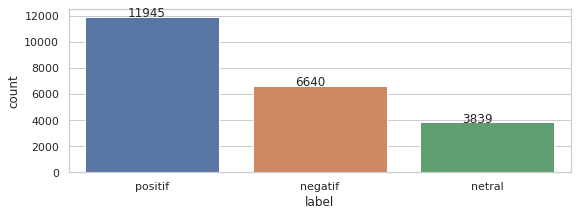

In [ ]:
# Mengecek keseimbangan label
print(df['label'].value_counts())
ax = sns.countplot(x=df["label"])
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.02))

sns.set(rc={'figure.figsize':(9,3)})
plt.show()

In [ ]:
#Untuk menentukkan MAX_SEQUENCE_LENGTH
length_of_the_messages = df['text_used'].str.split("\\s+")
print("Max number of words = ", length_of_the_messages.str.len().max())
print("Index = ", length_of_the_messages.str.len().idxmax())

Max number of words =  49
Index =  3965


In [ ]:
df.loc[3965,'text_used']

'thut v vvbb tv inie uji nasional bu eh v eh bu tv mm bu tuhanma nama h kivvbb h gmi sayang ii fb sayang nb tke mm fh vvbb bahasa nn buu handphone bn tv by bu gnb bahasa kakak loyh mm nn gnn bubnbn iignnlosi ii mum'

In [ ]:
#Untuk menentukkan MAX_NB_WORDS
new_df = df.copy()
new_df["mytext_new"] = new_df['text_used'].str.lower().str.replace('[^\w\s]','') #Replace alhpanumeric dan anchor '$'
new_df = new_df.mytext_new.str.split(expand=True).stack().value_counts().reset_index()
new_df.columns = ['Word', 'Frequency'] 
new_df

<ipython-input-5-7b260bb0d55f>:3: FutureWarning:

The default value of regex will change from True to False in a future version.



,Word,Frequency
0,bagus,6754
1,banget,4200
2,suka,1587
3,jadi,1386
4,lihat,1335
...,...,...
16212,janc,1
16213,bagustenang,1
16214,kebwah,1
16215,ikyyax,1


In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000 #Maksimal total jenis kata yang akan digunakan
# Max number of words in each statement.
MAX_SEQUENCE_LENGTH = 50 #Maksimal kata disetiap kalimat
# This is fixed.
EMBEDDING_DIM = 500

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text_used'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

#Random_State = 42

Found 16217 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['text_used'].values) #untuk konversi teks ke numerik
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) #membuat array teks sama panjang dengan menambah prefiks berupa angka 0
print('Shape of data address:', X.shape)

Shape of data address: (22424, 50)


In [ ]:
X

array([[   0,    0,    0, ...,    1,    2,   34],
       [   0,    0,    0, ...,    0,   26,  350],
       [   0,    0,    0, ...,    0, 3129, 4861],
       ...,
       [   0,    0,    0, ...,    0,    0, 2002],
       [   0,    0,    0, ...,    0,   44,    6],
       [   0,    0,    0, ...,  346,  601,   17]], dtype=int32)

In [ ]:
Y = df['tag']

In [ ]:
Y

0        2
1        0
2        1
3        0
4        1
        ..
22419    0
22420    2
22421    0
22422    0
22423    1
Name: tag, Length: 22424, dtype: int64

##Split Data and Save

In [ ]:
RANDOM_SEED = 42
#20(78%), 
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

X_val, X_test, Y_val, Y_test = train_test_split(
    X_test,
    Y_test,
    test_size=0.1,
    random_state=RANDOM_SEED,
)

In [ ]:
print(f'Total Data Train    : {len(X_train)}')
print(f'Total Data Validasi : {len(X_val)}')
print(f'Total Data Test     : {len(X_test)}')

Total Data Train    : 17939
Total Data Validasi : 4036
Total Data Test     : 449


In [ ]:
print('X_train:', X_train.shape,'Y_train:', Y_train.shape)
print('X_val:', X_val.shape, 'Y_val:', Y_val.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

X_train: (17939, 50) Y_train: (17939,)
X_val: (4036, 50) Y_val: (4036,)
X_test: (449, 50) Y_test: (449,)


In [ ]:
Y_test

7700     0
15737    1
17683    2
17469    0
3230     2
        ..
4338     2
14063    2
6311     2
2703     1
11143    2
Name: tag, Length: 449, dtype: int64

In [ ]:
X.shape[1]

50

#Create Model

In [ ]:
def create_model():
  model = Sequential()
  model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
  model.add(SpatialDropout1D(0.4))
  model.add(Dropout(0.8)) #Dropout neuron untuk mengurangi overfitting
  model.add(LSTM(128,return_sequences=True)) 
  model.add(LSTM(16))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model = create_model()

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 500)           5000000   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 50, 500)          0         
 lDropout1D)                                                     
                                                                 
 dropout_3 (Dropout)         (None, 50, 500)           0         
                                                                 
 lstm_6 (LSTM)               (None, 50, 128)           322048    
                                                                 
 lstm_7 (LSTM)               (None, 16)                9280      
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                      

In [ ]:
X.shape

(22424, 50)

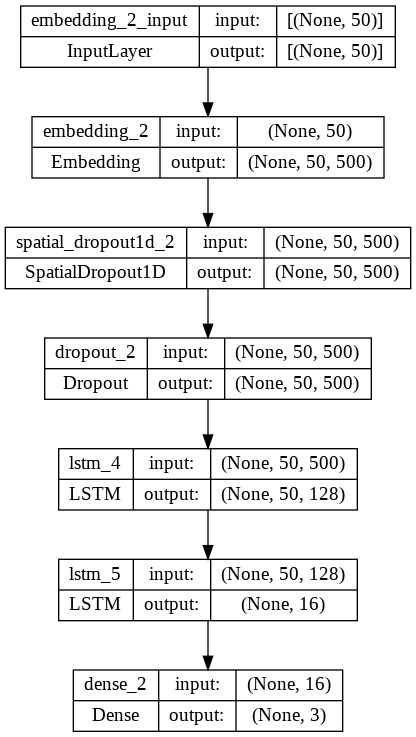

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 20
batch_size = 64

history = model.fit(
    X_train, 
    Y_train, 
    epochs=epochs, 
    batch_size=batch_size,
    validation_data = (X_val, Y_val),
    # validation_split=0.15,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
281/281 [==============================] - 7s 17ms/step - loss: 0.7875 - accuracy: 0.6590 - val_loss: 0.6547 - val_accuracy: 0.7374
Epoch 2/20
281/281 [==============================] - 4s 13ms/step - loss: 0.6130 - accuracy: 0.7600 - val_loss: 0.6088 - val_accuracy: 0.7641
Epoch 3/20
281/281 [==============================] - 4s 13ms/step - loss: 0.5537 - accuracy: 0.7896 - val_loss: 0.5987 - val_accuracy: 0.7745
Epoch 4/20
281/281 [==============================] - 4s 13ms/step - loss: 0.5125 - accuracy: 0.8074 - val_loss: 0.5971 - val_accuracy: 0.7718
Epoch 5/20
281/281 [==============================] - 4s 13ms/step - loss: 0.4778 - accuracy: 0.8225 - val_loss: 0.6021 - val_accuracy: 0.7738
Epoch 6/20
281/281 [==============================] - 4s 13ms/step - loss: 0.4500 - accuracy: 0.8341 - val_loss: 0.6156 - val_accuracy: 0.7711
Epoch 7/20
281/281 [==============================] - 4s 15ms/step - loss: 0.4229 - accuracy: 0.8458 - val_loss: 0.6413 - val_accuracy: 0.7671

In [ ]:
#save history
import pickle
with open('/content/drive/MyDrive/...', 'wb') as file_pi:
  pickle.dump(model_history.history, file_pi)

In [ ]:
import pickle
with open('/content/drive/MyDrive/...', "rb") as file_pi:
    model_history = pickle.load(file_pi)

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

15/15 [==============================] - 0s 6ms/step - loss: 0.6511 - accuracy: 0.7773
Test set
  Loss: 0.651
  Accuracy: 0.777


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(y= model_history.history["accuracy"], x=model_history.epoch,mode="lines+markers", name="Training accuracy"))
fig.add_trace(go.Scatter(y= model_history.history["val_accuracy"], x=model_history.epoch,mode="lines+markers", name="Val accuracy"))
fig.show()

fig = go.Figure() 
fig.add_trace(go.Scatter(y= model_history.history["loss"], x= model_history.epoch,mode="lines+markers", name="Training loss"))
fig.add_trace(go.Scatter(y= model_history.history["val_loss"], x= model_history.epoch,mode="lines+markers", name="Val loss"))
fig.show()

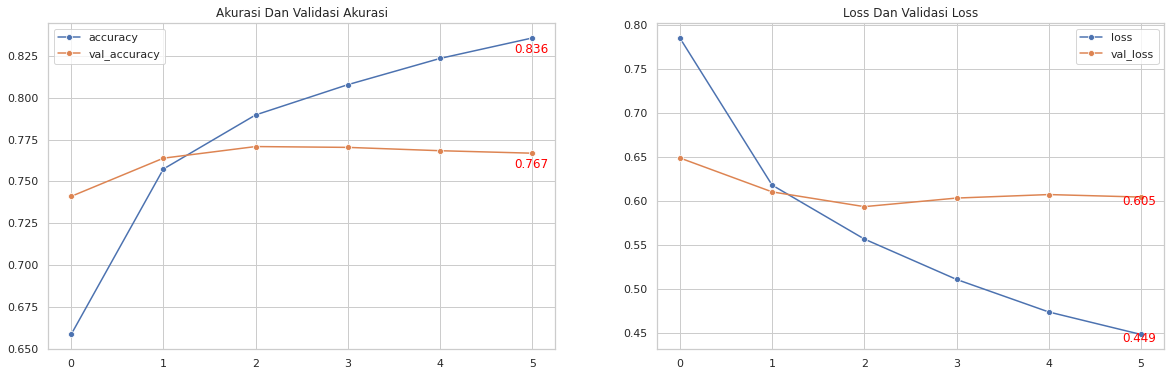

In [ ]:
sns.set_style(style='whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(20,6))
graph = ['accuracy', 'loss']
title = ["Akurasi Dan Validasi Akurasi", "Loss Dan Validasi Loss"]

def draw_graph(i, text, title):
    axes[i].set_title(title)
    fig = sns.lineplot(ax=axes[i], x=model_history.epoch, y=model_history.history[text], marker='o')
    axes[i].legend([text, f'val_{text}'])
    fig = sns.lineplot(ax=axes[i], x=model_history.epoch, y=model_history.history[f'val_{text}'], marker='o')
    axes[i].legend([text, f'val_{text}'])

def text_graph(i, text):
    for j, (x, y) in enumerate(zip(model_history.epoch, model_history.history[f'{text}'])):
        if j == 5:
          axes[i].text(x = x - 0.2, y = y - 0.009, s = round(y, 3), color = 'red') 
    for j, (x, y) in enumerate(zip(model_history.epoch, model_history.history[f'val_{text}'])):
        if j == 5:
          axes[i].text(x = x - 0.2, y = y - 0.009, s = round(y, 3), color = 'red') 

for i, (val, tit) in enumerate(zip(graph, title)):
    draw_graph(i, val, tit)
    text_graph(i, val)

#Save and Load Model

In [ ]:
# model.save("/content/drive/MyDrive/...")

In [ ]:
#Load Model
new_model = tf.keras.models.load_model('/content/drive/MyDrive/...')

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000 #Maksimal total jenis kata yang akan digunakan
# Max number of words in each statement.
MAX_SEQUENCE_LENGTH = 50 #Maksimal kata disetiap kalimat
# This is fixed.
EMBEDDING_DIM = 500

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text_used'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

#Random_State = 42

Found 16217 unique tokens.


In [ ]:
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 500)           5000000   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 50, 500)          0         
 lDropout1D)                                                     
                                                                 
 dropout_3 (Dropout)         (None, 50, 500)           0         
                                                                 
 lstm_6 (LSTM)               (None, 50, 128)           322048    
                                                                 
 lstm_7 (LSTM)               (None, 16)                9280      
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                      

#Evaluate

In [ ]:
y_pred = new_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

15/15 [==============================] - 1s 5ms/step


In [ ]:
y_pred

array([2, 2, 2, 0, 2, 1, 0, 2, 1, 2, 0, 2, 0, 2, 0, 0, 0, 2, 1, 2, 2, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2,
       1, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 0, 0, 2, 0,
       2, 1, 0, 1, 1, 1, 0, 2, 0, 0, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 1,
       2, 1, 0, 1, 2, 2, 1, 2, 1, 0, 2, 2, 2, 2, 0, 1, 2, 0, 2, 2, 0, 2,
       2, 1, 0, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0,
       0, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0,
       1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 0, 2, 0, 2, 2,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 1, 2, 2,
       2, 1, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 1, 2, 0, 1, 0, 2, 2, 2, 2,
       1, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 1, 2, 0, 2, 2, 2, 0,
       2, 2, 2, 0, 1, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 1, 1,

In [ ]:
y_true = Y_test

In [ ]:
y_true

7700     0
15737    1
17683    2
17469    0
3230     2
        ..
4338     2
14063    2
6311     2
2703     1
11143    2
Name: tag, Length: 449, dtype: int64

In [ ]:
print(classification_report(y_true, y_pred, target_names=["Negatif", "Netral", "Positif"]))

              precision    recall  f1-score   support

     Negatif       0.74      0.74      0.74       138
      Netral       0.66      0.41      0.50        71
     Positif       0.82      0.91      0.86       240

    accuracy                           0.78       449
   macro avg       0.74      0.69      0.70       449
weighted avg       0.77      0.78      0.77       449



In [ ]:
print(confusion_matrix(y_true, y_pred, normalize='pred'))

[[0.73913043 0.22727273 0.09737828]
 [0.13768116 0.65909091 0.08614232]
 [0.12318841 0.11363636 0.8164794 ]]


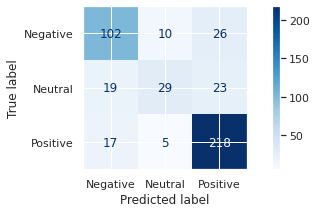

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Negative','Neutral','Positive'])
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')

plt.show()

#Custom Test

In [ ]:
df.tag.unique()

array([2, 0, 1])

In [ ]:
new_text = ['aplikasi tiktok sangat bagus sekali, saya suka']
seq = tokenizer.texts_to_sequences(new_text)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = new_model.predict(padded)
labels = ['Negatif', 'Netral', 'Positif']

print('Kalimat : ',labels[np.argmax(pred)])
print('Negatif : ',pred[0,0])
print('Netral  : ',pred[0,1])
print('Positif : ',pred[0,2])

1/1 [==============================] - 1s 817ms/step
Kalimat :  Positif
Negatif :  0.025984228
Netral  :  0.073796764
Positif :  0.900219


In [ ]:
input_text = str(input("Tulis Ulasan: "))
new_text = [input_text]
seq = tokenizer.texts_to_sequences(new_text)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = new_model.predict(padded)
labels = ['Negatif', 'Netral', 'Positif']

print('Kalimat : ',labels[np.argmax(pred)])
print('Negatif : ',pred[0,0])
print('Netral  : ',pred[0,1])
print('Positif : ',pred[0,2])

Tulis Ulasan: Mama papa bangga
1/1 [==============================] - 0s 17ms/step
Kalimat :  Positif
Negatif :  0.02159533
Netral  :  0.45908406
Positif :  0.51932055


Test Model
Run Dataset -> Run Tokenizer -> Load Model -> Test